In [1]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import cortex
import copy

%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from utils import plot_utils, nsd_utils
from utils.plot_utils import get_full_surface
plot_utils.set_plotting_defaults()

In [2]:
# Load results of the fitting procedure

subject = 1
volume_space=False
fitting_type = 'gabor_solo_ridge_4ori_4sf'
root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = plot_utils.load_fit_results(subject, volume_space, fitting_type, n_from_end=0, root=root, verbose=True);
plot_utils.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01_surface/gabor_solo_ridge_4ori_4sf/Sep-09-2021_2224_03/all_fit_params

dict_keys(['voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'n_prf_sd_out', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'feature_table_simple', 'filter_pars_simple', 'orient_filters_simple', 'feature_table_complex', 'filter_pars_complex', 'orient_filters_complex', 'feature_types_exclude', 'feature_info', 'nonlin_fn', 'padding_mode', 'autocorr_output_pix'])
voxel_mask: shape (453622,)
image_order: shape (7500,)
voxel_index: len 1
voxel_roi: len 2
voxel_ncsnr: shape (453622,)
aperture = 1.0
aperture_rf_range = 1.1
models: shape (875, 3)
n_prf_sd_out = 2
best_losses: shape (66545, 1)
best_lambdas: shape (66545, 1)
best_params: len 6
lambdas:

In [5]:
out['best_params'][1]

array([[[-0.00787315],
        [ 0.01070587],
        [ 0.0230214 ],
        ...,
        [ 0.07685467],
        [-0.00370785],
        [ 0.06441928]],

       [[-0.01085788],
        [ 0.01092643],
        [ 0.02015583],
        ...,
        [ 0.07357261],
        [ 0.00295267],
        [ 0.06162226]],

       [[-0.01240762],
        [ 0.01661349],
        [ 0.01606579],
        ...,
        [ 0.06989071],
        [ 0.00789268],
        [ 0.05535429]],

       ...,

       [[-0.01700291],
        [ 0.02027716],
        [ 0.00389692],
        ...,
        [ 0.01890737],
        [ 0.00792023],
        [-0.04658058]],

       [[ 0.02741775],
        [-0.01391174],
        [ 0.02678339],
        ...,
        [-0.02442075],
        [-0.01978069],
        [-0.00715839]],

       [[ 0.01540555],
        [-0.01149112],
        [ 0.00441342],
        ...,
        [-0.037479  ],
        [ 0.00372207],
        [ 0.0042133 ]]], dtype=float32)

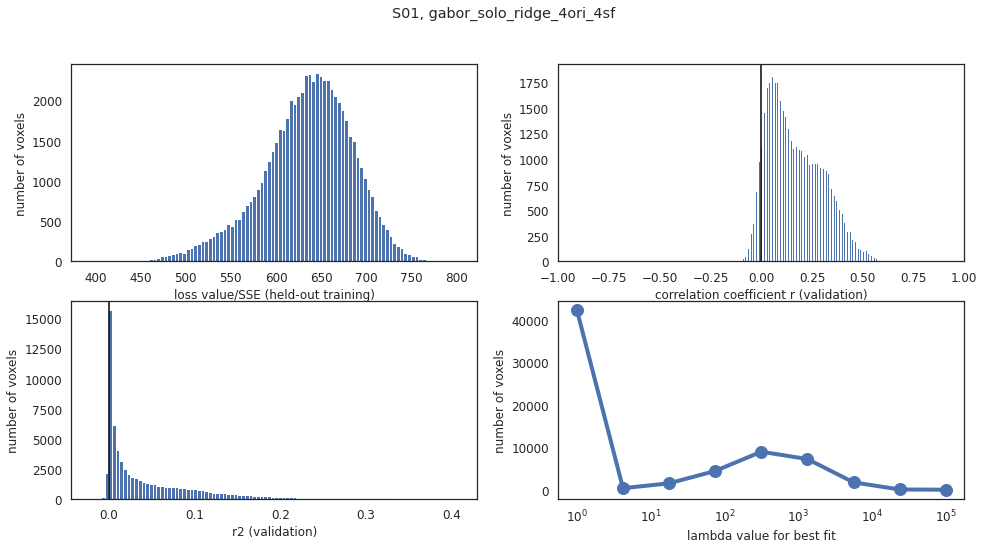

In [6]:
plot_utils.plot_perf_summary(subject, fitting_type, out, fig_save_folder=fig_save_folder)

In [3]:
# plot_utils.plot_fit_summary_volume_space(subject, fitting_type,out, fig_save_folder)

In [4]:
plot_utils.plot_summary_pycortex(subject, fitting_type, out, port=44447)

navigate browser to: 127.0.0.1:44447
Started server on port 44447


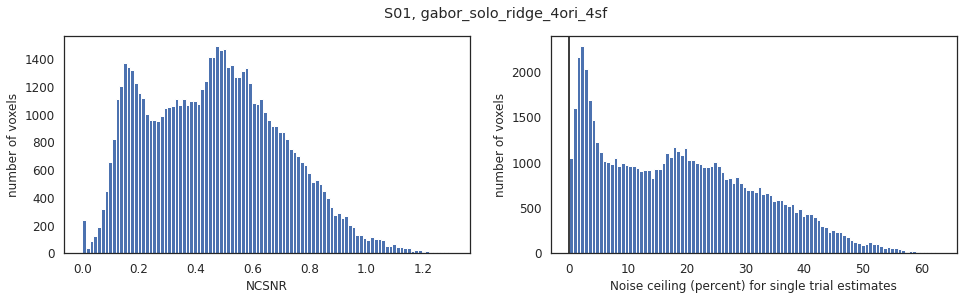

In [7]:
plot_utils.plot_noise_ceilings(subject, fitting_type,out, fig_save_folder)

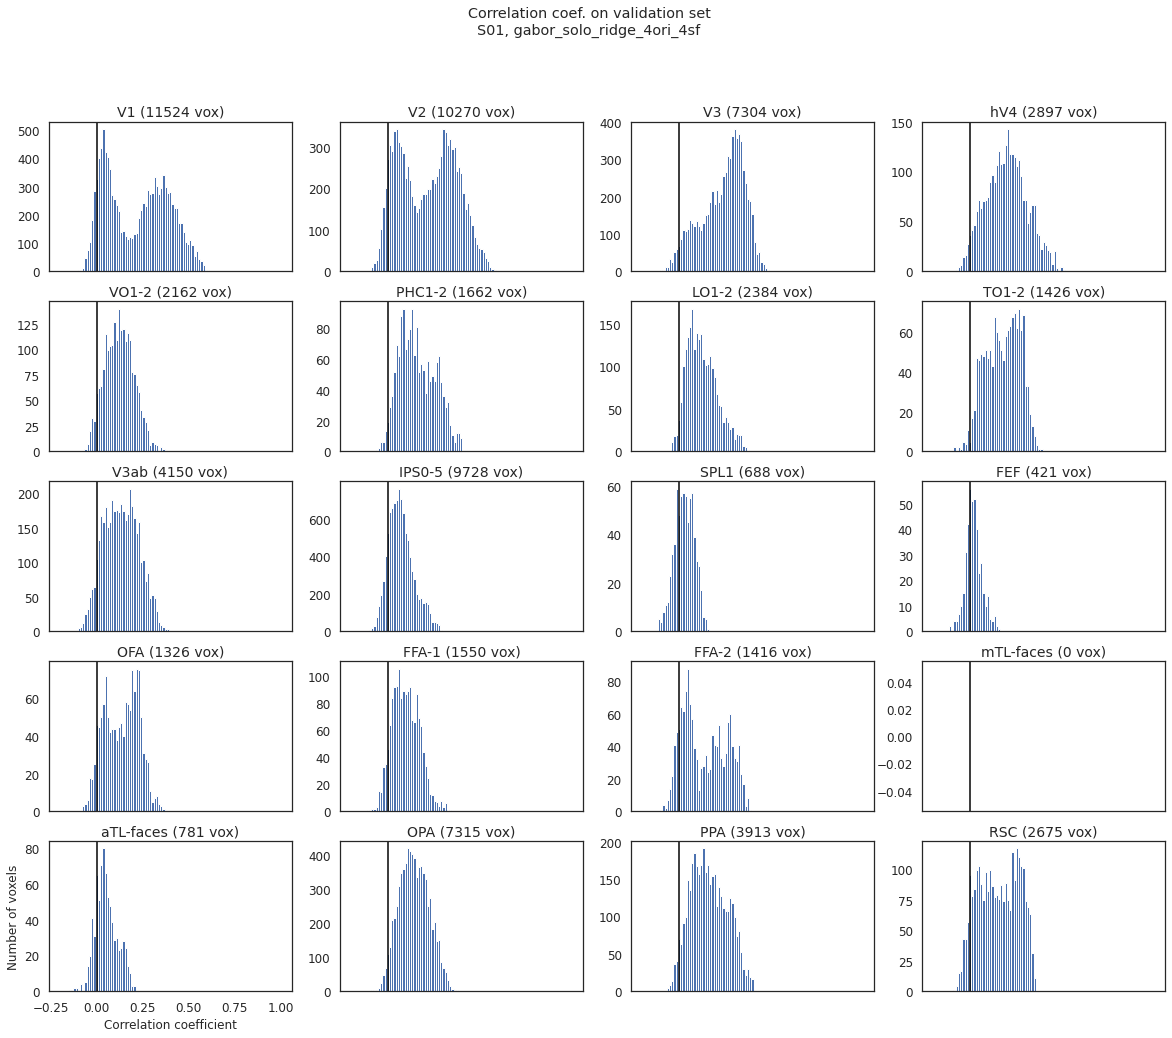

In [5]:
plot_utils.plot_cc_each_roi(subject, fitting_type,out, fig_save_folder)

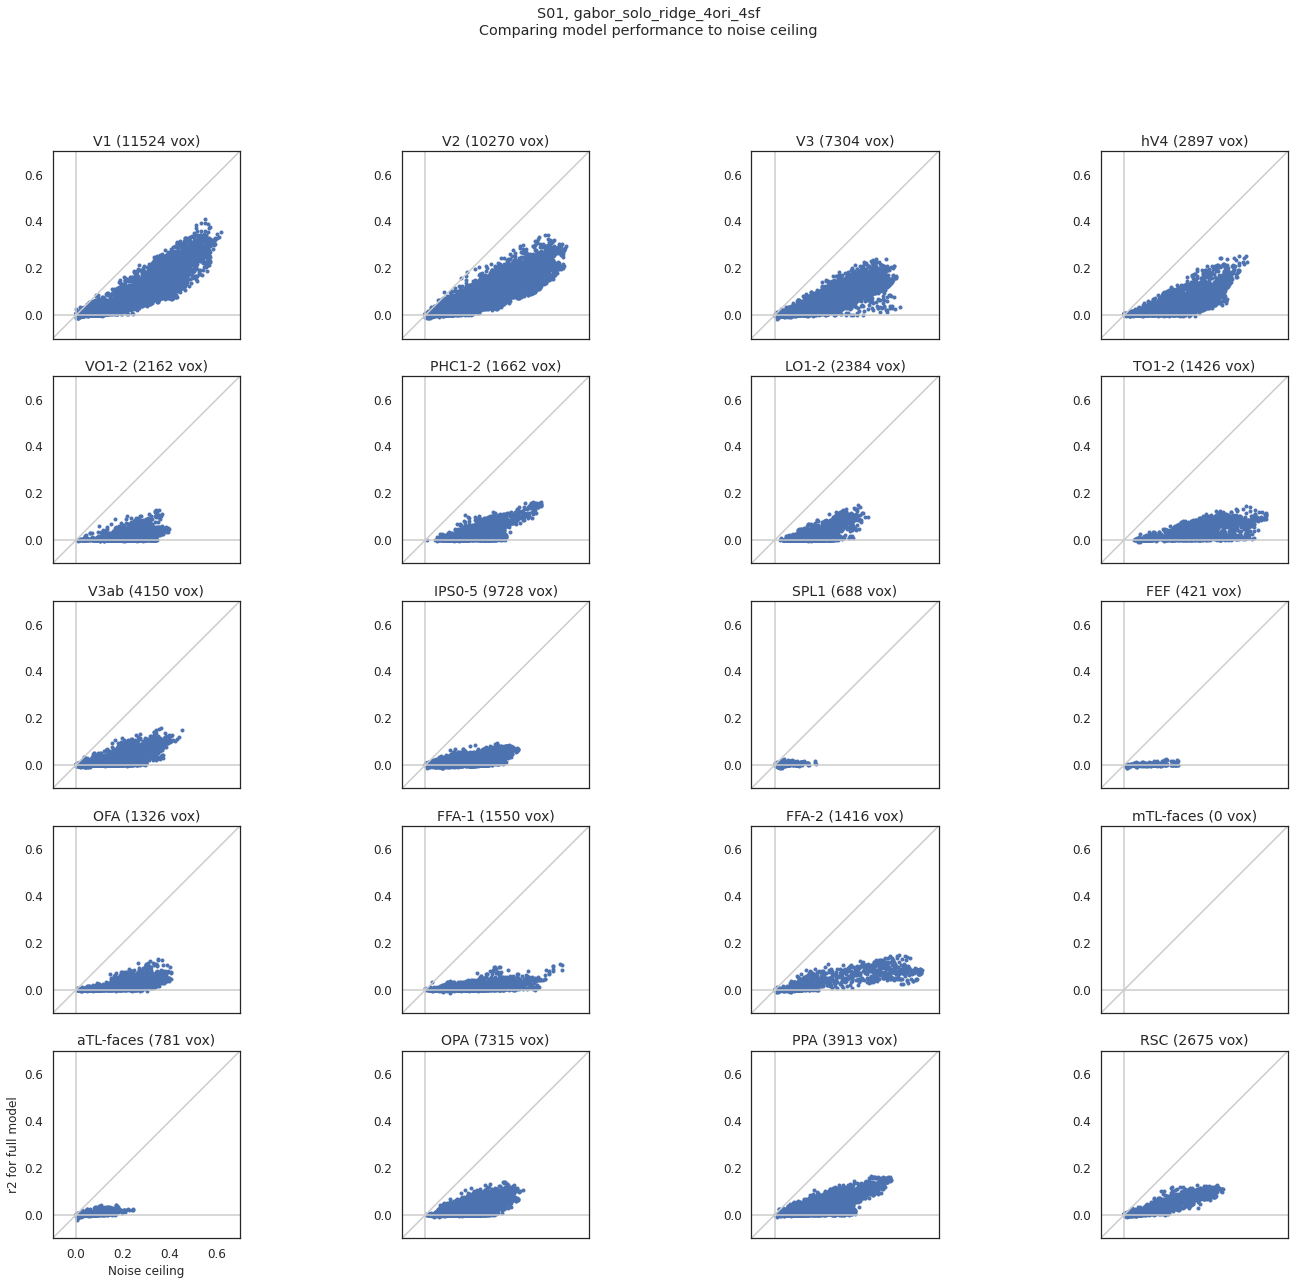

In [6]:
plot_utils.plot_r2_vs_nc(subject, fitting_type,out, fig_save_folder)

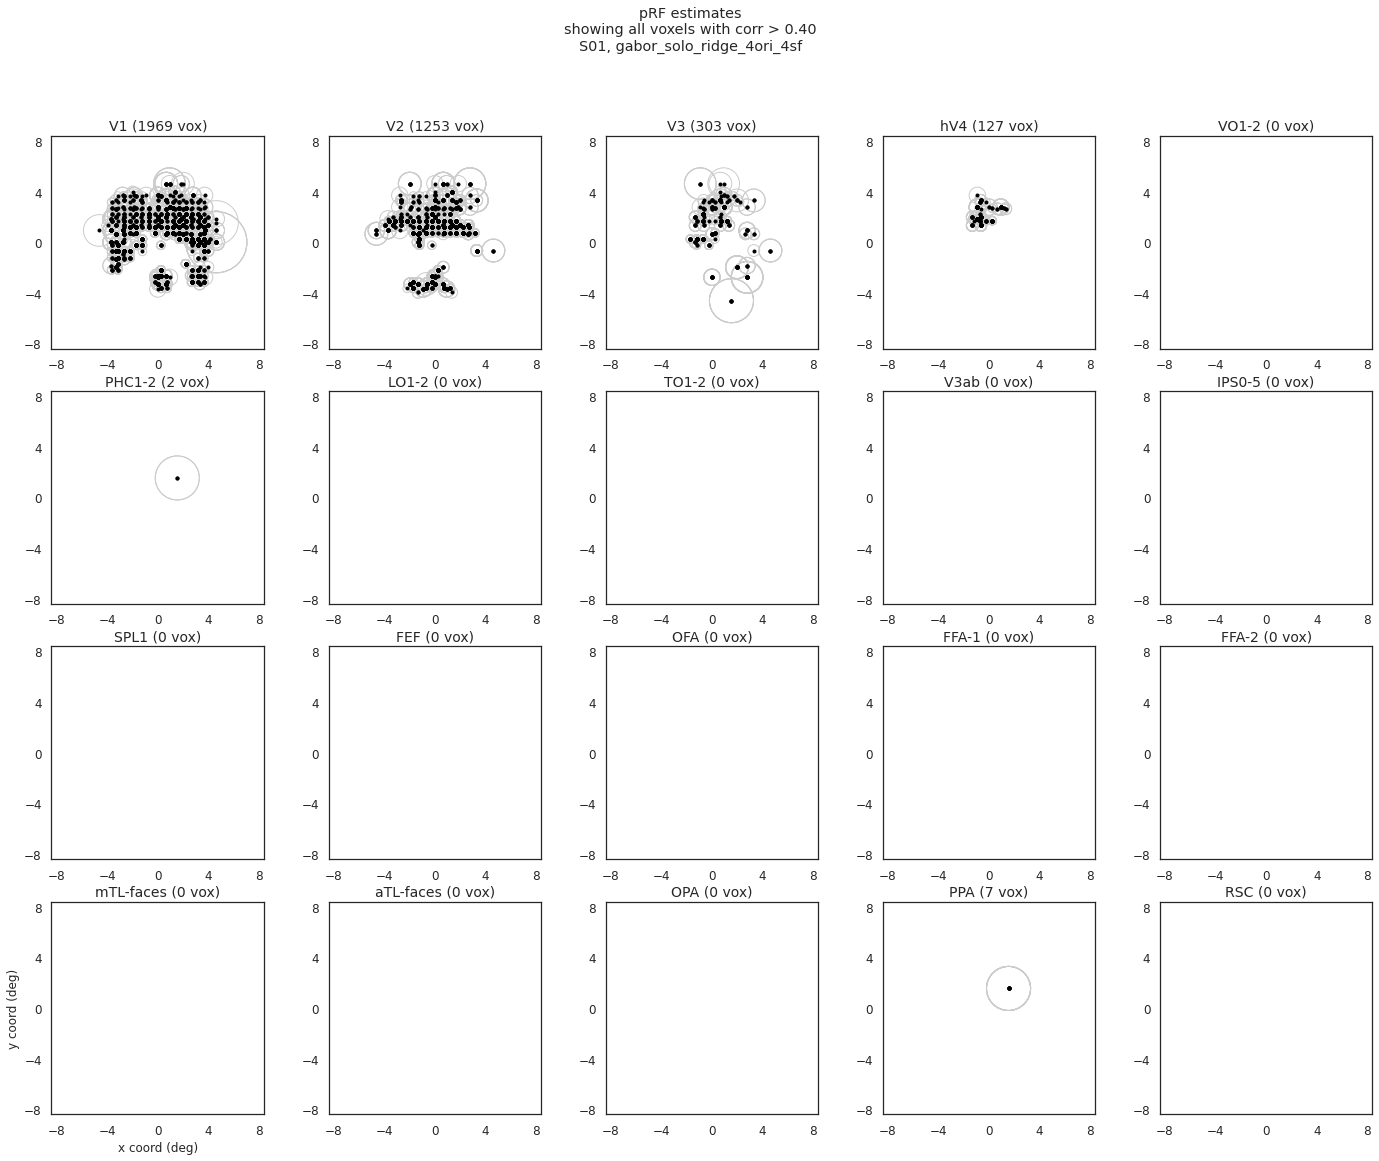

In [11]:
plot_utils.plot_spatial_rf_circles(subject, fitting_type,out, cc_cutoff = 0.40, fig_save_folder=fig_save_folder)

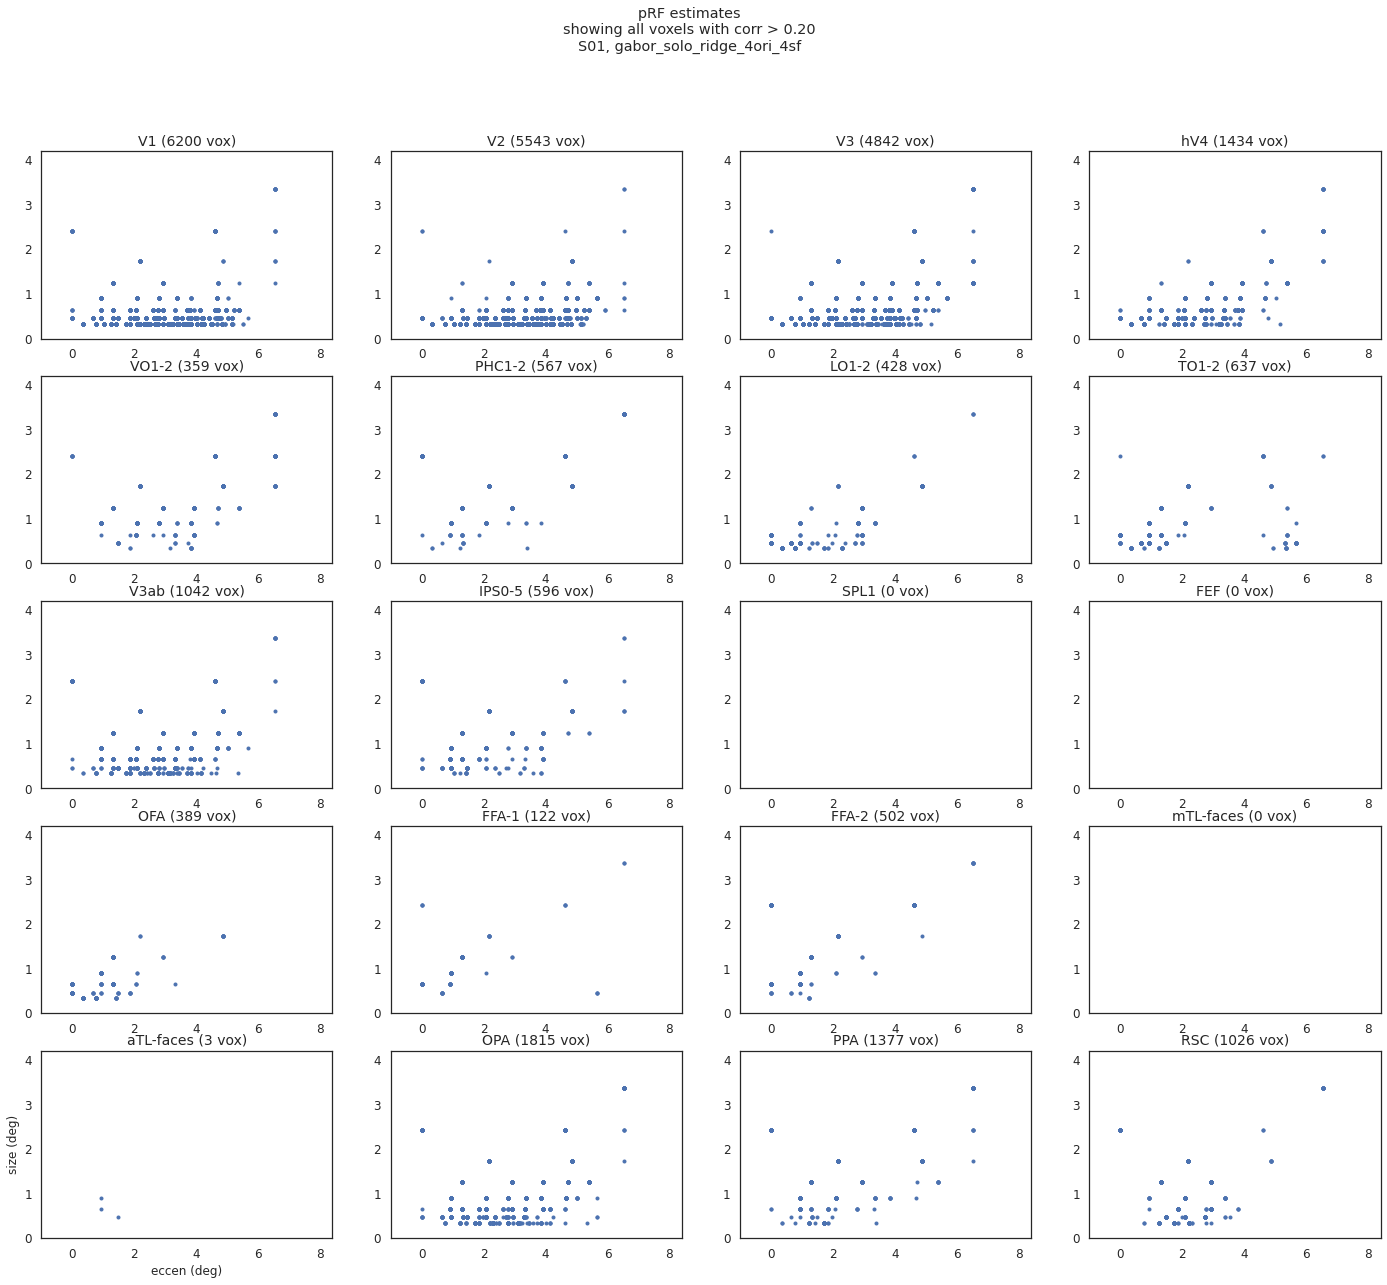

In [12]:
plot_utils.plot_size_vs_eccen(subject, fitting_type, out, cc_cutoff=0.2, fig_save_folder=fig_save_folder)

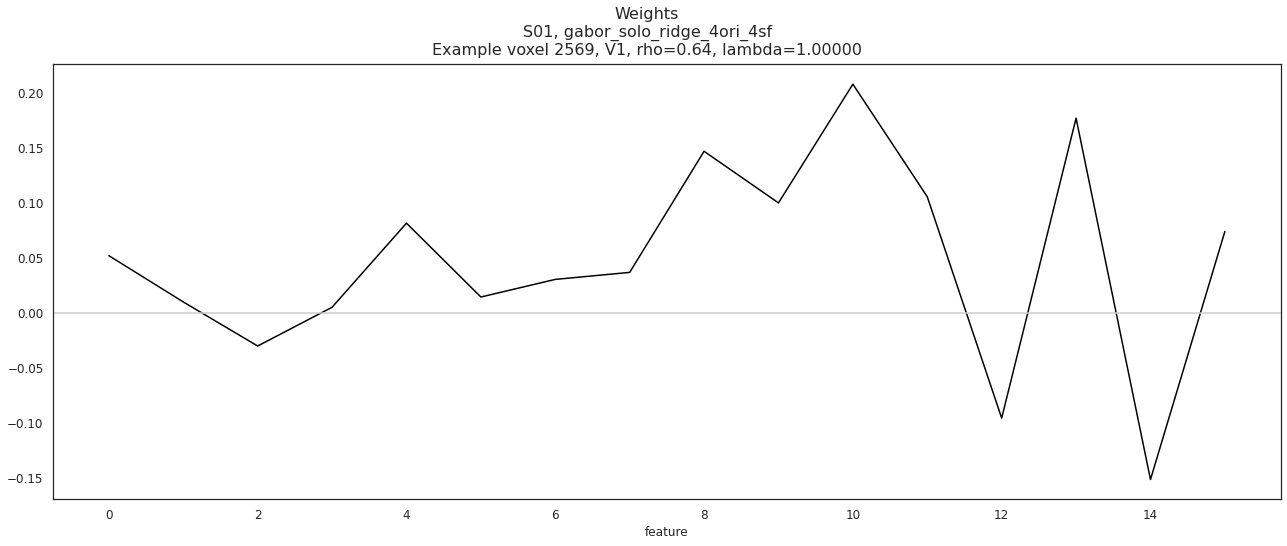

In [13]:
# Plotting some example weights...

from copy import deepcopy
roi_labels_retino, roi_labels_categ, ret_group_inds, categ_group_inds, ret_group_names, categ_group_names, \
        n_rois_ret, n_rois_categ, n_rois = plot_utils.get_roi_info(subject, out)

pp=0
val_cc = out['val_cc'][:,0]
lambdas = out['lambdas']
best_lambdas = out['best_lambdas']
vox2plot = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance

vv=vox2plot

plt.figure(figsize=(22,8))

weights = out['best_params'][1]
wts = weights[vv,:]
plt.plot(wts,'-',color='k')

plt.axhline(0,color=[0.8, 0.8, 0.8])

plt.xlabel('feature')

roi_ind_ret = np.where([np.isin(roi_labels_retino[vv], ret_group_inds[ii]) for ii in range(len(ret_group_inds))])[0]
roi_ind_categ = np.where([np.isin(roi_labels_categ[vv], categ_group_inds[ii]) for ii in range(len(categ_group_inds))])[0]
if len(roi_ind_ret)==0:
    rname = categ_group_names[roi_ind_categ[0]]
elif len(roi_ind_categ)==0:
    rname = ret_group_names[roi_ind_ret[0]]
else:
    rname = '%s/%s'%(ret_group_names[roi_ind_ret[0]],categ_group_names[roi_ind_categ[0]])
    
plt.title(''%())

plt.suptitle('Weights\nS%02d, %s\nExample voxel %d, %s, rho=%.2f, lambda=%.5f'%( subject, fitting_type,vv,rname, val_cc[vv],lambdas[best_lambdas[vv]]),fontsize=16);
